# Example notebook for patch generation from an ImageCollection

Here, we load an ImageCollection from a butler, and a use an ephemeris table for a specific objec to filter down an ImageCollection which matches it. Here we take a specific table and we run it?

In [1]:
# Install LSST Stack and KBMOD here. GPU support is optional.

In [2]:
!pip install -e /sdf/home/w/wbeebe/kbmod_dev/kbmod

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sdf/home/w/wbeebe/kbmod_dev/kbmod
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for kbmod (pyproject.toml) ... done
  Created wheel for kbmod: filename=kbmod-1.1.1.dev1302+g9825b624.d20250310-0.editable-cp311-cp311-linux_x86_64.whl size=6766 sha256=2fa0cd906aea9d232e60219f96ce00f5b7a4dc4580030226631594c1737cceb0
  Stored in directory: /lscratch/wbeebe/tmp/pip-ephem-wheel-cache-103bw2pm/wheels/ed/cb/88/abc5748dafadefada9195f9d11e66129d219fc538675449a80
Successfully built kbmod
  Attempting uninstall: kbmod
    Found existing installation: kbmod 1.1.1.dev1302+g9825b624.d20250310
    Uninstalling kbmod-1.1.1.dev1302+g9825b624.d20250310:
      Successfully uninstalled kbmod-1.1.1.dev1302+g9825b624.d20250310


: 

In [3]:
# find commmand for serach for notebooks
import kbmod

: 

In [4]:
from kbmod.region_search_new import RegionSearch, Ephems, PatchGrid, Patch

: 

: 

In [5]:
!pip install /sdf/home/w/wbeebe/kbmod_dev/sphgeom

Defaulting to user installation because normal site-packages is not writeable
Processing /sdf/home/w/wbeebe/kbmod_dev/sphgeom
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lsst-sphgeom: filename=lsst_sphgeom-28.2025.600-cp311-cp311-linux_x86_64.whl size=635331 sha256=a1dcb3ba03fdda9b56bbd3d55702c0eee1c2ce8d7a9357958c66bc44899ac4f5
  Stored in directory: /lscratch/wbeebe/tmp/pip-ephem-wheel-cache-tkydr_9s/wheels/b8/11/1d/7f6277795684c9df04a53362910ef33f2782890a2932f6db6f
Successfully built lsst-sphgeom
  Attempting uninstall: lsst-sphgeom
    Found existing installation: lsst-sphgeom 28.2025.600
    Uninstalling lsst-sphgeom-28.2025.600:
      Successfully uninstalled lsst-sphgeom-28.2025.600


: 

In [6]:
!setup lsst_distrib

: 

In [7]:
import lsst

# from lsst.sphgeom import , Point2D, Point2I, Extent2I
# import lsst.daf.butler as dafButler
# from lsst.daf.butler import DatasetNotFoundError
from dateutil import parser
from tqdm import tqdm  # Import tqdm for the progress bar
from astropy.time import Time
from astropy.table import Table, join, unique
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic, ICRS
from astropy import units as u
# from lsst.sphgeom import degrees, SpherePoint

import numpy as np
import pandas as pd
import os
import glob
import pickle

import os
import json
from tqdm.contrib.concurrent import process_map
from astropy.table import Table
import pandas as pd
from functools import partial

from matplotlib import pyplot as plt

import kbmod
from kbmod.reprojection_utils import correct_parallax_geometrically_vectorized
from dateutil import parser

from astropy.coordinates import EarthLocation

from shapely import Polygon

from astropy.table import Table

: 

### First we load our ImageCollection of metadata ingested from the Butler

In [8]:
ic_path = "/sdf/home/w/wbeebe/rubin-user/image_collections_interest/LSSTComCam_runs_DRP_20241101_20241211_w_2024_50_DM-48128.collection"
ic = kbmod.ImageCollection.read(ic_path)

: 

In [9]:
ic[0]

dataId,visit,detector,band,filter,exposureTime,mjd_start,mjd_mid,object,pointing_ra,pointing_dec,airmass,wcs_err,ra,dec,ra_bl,dec_bl,ra_tl,dec_tl,ra_tr,dec_tr,ra_br,dec_br,psfSigma,psfArea,nPsfStar,zeroPoint,skyBg,skyNoise,meanVar,OBSID,wcs,collection,datasetType,obs_lon,obs_lat,obs_elev,astromOffsetMean,astromOffsetStd,DIMM2SEE
str36,int64,int64,str1,str4,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str20,str1250,str56,str28,float64,float64,float64,float64,float64,float64
5169c17f-bb8e-40fc-96fe-4b83597df8d2,2024121000425,5,r,r_03,30.0,60655.246048379566,60655.246227777716,ECDFS,53.1535514707645,-28.1366415006451,1.28221752878834,7.389644451905042e-12,53.06954262581797,-27.897443132978164,52.96407662659122,-28.025936551475983,53.213249586117634,-27.99278183375829,53.17477735760019,-27.768765919922007,52.92605768657792,-27.801902010137347,2.6504541883182724,104.39609322175905,12,28.843851284429732,12016.643432892859,110.90657332947406,12674.77983670926,CC_O_20241210_000425,"{""WCSAXES"":2,""CRPIX1"":1876.80818,""CRPIX2"":1606.826387,""PC1_1"":-8.2913018496199e-06,""PC1_2"":5.5004810809004e-05,""PC2_1"":5.501400877254e-05,""PC2_2"":8.2742710184711e-06,""CDELT1"":1.0,""CDELT2"":1.0,""CUNIT1"":""deg"",""CUNIT2"":""deg"",""CTYPE1"":""RA---TAN-SIP"",""CTYPE2"":""DEC--TAN-SIP"",""CRVAL1"":53.046512811648,""CRVAL2"":-27.909519987183,""LONPOLE"":180.0,""LATPOLE"":-27.909519987183,""MJDREF"":0.0,""RADESYS"":""ICRS"",""A_ORDER"":2,""A_0_2"":2.75047185170942e-08,""A_1_1"":4.77197407786723e-08,""A_2_0"":1.43959205438269e-07,""B_ORDER"":2,""B_0_2"":9.34929031325792e-09,""B_1_1"":5.69354902560917e-08,""B_2_0"":5.25326913173219e-09,""AP_ORDER"":3,""AP_0_0"":8.37031900683543e-08,""AP_0_1"":1.68134578934616e-11,""AP_0_2"":-2.7504735693173e-08,""AP_0_3"":1.82618424137253e-15,""AP_1_0"":5.09001729653846e-11,""AP_1_1"":-4.7719790749426e-08,""AP_1_2"":1.37700778366748e-14,""AP_2_0"":-1.4395929829367e-07,""AP_2_1"":2.36047949440854e-14,""AP_3_0"":4.16839635398811e-14,""BP_ORDER"":3,""BP_0_0"":1.44460159670015e-08,""BP_0_1"":5.99342797613644e-12,""BP_0_2"":-9.3492958090984e-09,""BP_0_3"":1.74046933566411e-15,""BP_1_0"":7.16494535853563e-12,""BP_1_1"":-5.6935508943469e-08,""BP_1_2"":4.60131931282903e-15,""BP_2_0"":-5.2532783179329e-09,""BP_2_1"":1.20343473665591e-14,""BP_3_0"":1.81041332632278e-15,""NAXIS1"":4072,""NAXIS2"":4000}",LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128,goodSeeingDiff_differenceExp,-70.7494170285165,-30.2446389756252,2662.99616375123,nan,nan,0.0


: 

In [10]:
# We want to instantiate a RegionSearch object that will allow us to search for objects in a region of the sky.
# Here we will first generate a set of SkyPatches. We will then use these SkyPatches to search for objects in the
# region of the sky that they cover.

: 

In [11]:
patch_size = [20, 20]

# Note that at table creation we
# perform reflex-correction of all corners and generate shapely objects
region_search = kbmod.region_search_new.RegionSearch(
    ic, guess_dists=[39.0], earth_loc=EarthLocation.of_site("Rubin")
)


def patch_arcmin_to_pixels(patch_size, pixel_scale):
    """Operate on the self.patch_size array (with size (2,1)) to convert to
    pixels. Uses self.pixel_scale to do the conversion.

    Returns
    -------
    nd.array
        A 2d array with shape (2,1) containing the width and height of the
        patch in pixels.
    """
    patch_pixels = int(np.ceil(patch_size * 60 / pixel_scale))
    return patch_pixels


region_search.generate_patches(
    arcminutes=patch_size[0],
    overlap_percentage=50,
    image_width=patch_arcmin_to_pixels(patch_size[0], 0.2),
    image_height=patch_arcmin_to_pixels(patch_size[1], 0.2),
    pixel_scale=0.2,
)

: 

In [12]:
region_search.get_patches()[0]

: 

In [13]:
# TODO SkyTable path, convert hms_dms_to_degrees and save new
skytablepath = f"/sdf/home/c/colinc/skytable.csv"
ephems39 = Table.from_pandas(pd.read_csv(skytablepath))

: 

In [14]:
ephems39.sort("mjd_mid")

: 

In [15]:
print(
    f"Before filtering by time, there are {len(region_search.ic)} images in the collection."
)

# filter table by date

tnos_39 = ephems39[(ephems39["Name"] == "2013 TA228")]
region_search.filter_by_mjds(tnos_39["mjd_mid"], time_sep_s=60)

print(
    f"After filtering by time, there are {len(region_search.ic)} images in the collection."
)

Before filtering by time, there are 17205 images in the collection.
After filtering by time, there are 1021 images in the collection.


: 

In [16]:
# Now we will search for objects in the region of the sky that we are interested in. We will use the SkyPatches that we
# generated earlier to search for objects in the region of the sky that they cover.
# We will return a dictionary matching how for each patch with our object of interest, how many
# observations were found.
# Note that this will perform reflex-correction on the objects before searching for them.
region_search_ephems = kbmod.region_search_new.Ephems(
    tnos_39,
    ra_col="ra",
    dec_col="dec",
    mjd_col="mjd_mid",
    guess_dists=[39.0],
    earth_loc=EarthLocation.of_site("Rubin"),
)
found_patches = region_search.search_patches(
    region_search_ephems, guess_dist=39.0, max_overlapping_patches=4
)

: 

: 

In [17]:
len(found_patches)

4

: 

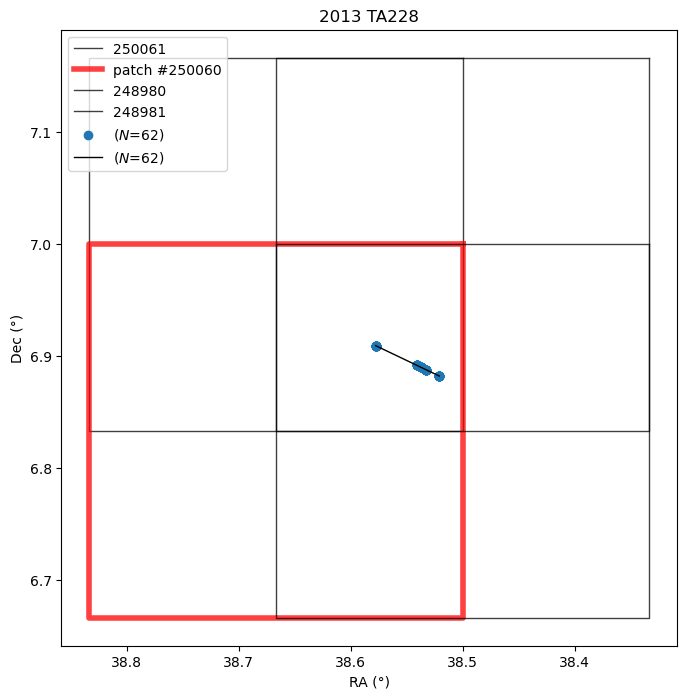

: 

In [18]:
from matplotlib import pyplot as plt

tno_name = "2013 TA228"
fig = plt.figure(figsize=[8, 8])
desired_patch = 250060
other_patches = [250060, 250061, 248981]
for patch_idx in found_patches:  # + other_patches:
    color = "black"
    lw = 1
    patchlabel = patch_idx  # None
    if patch_idx == desired_patch:
        color = "red"  # continue
        lw = 4
        patchlabel = f"patch #{patch_idx}"
    patch = region_search.get_patches()[patch_idx]
    radebox = [
        (patch.tl_ra, patch.tl_dec),
        (patch.tr_ra, patch.tr_dec),
        (patch.br_ra, patch.br_dec),
        (patch.bl_ra, patch.bl_dec),
        (patch.tl_ra, patch.tl_dec),
    ]
    plt.plot(
        [coord[0] for coord in radebox],
        [coord[1] for coord in radebox],
        label=patchlabel,
        alpha=0.75,
        color=color,
        linewidth=lw,
    )
# days_obs = list(set(list(tnoEphemTable['day_obs'])))
all_ras = []
all_decs = []
# for day_obs in days_obs:
ephem_ras = region_search_ephems.get_ras(39.0)
ephem_decs = region_search_ephems.get_decs(39.0)
"""
for i in range(len(day_ephem)):
    # rade = hms_dms_to_degrees(day_ephem['RA (hms)'][i], day_ephem['DEC (dms)'][i])
    rade = [day_ephem['ra'][i], day_ephem['dec'][i]]
    ephem_ras.append(rade[0])
    ephem_decs.append(rade[1])
"""
plt.scatter(ephem_ras, ephem_decs, label=f"($N$={len(ephem_ras)})")
for ra in ephem_ras:
    all_ras.append(ra)
for DEC in ephem_decs:
    all_decs.append(DEC)
plt.plot(all_ras, all_decs, label=f"($N$={len(ephem_ras)})", linewidth=1, color="black")
plt.legend()
plt.xlabel(f"RA (°)")
plt.ylabel(f"Dec (°)")
plt.title(f"{tno_name}")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal")
plt.savefig(f"{tno_name}_extra_patches.png")

In [19]:
copy_ic = kbmod.ImageCollection(region_search.ic.data.copy(), validate=False)

: 

In [20]:
copy_ic

dataId,visit,detector,band,filter,exposureTime,mjd_start,mjd_mid,object,pointing_ra,pointing_dec,airmass,wcs_err,ra,dec,ra_bl,dec_bl,ra_tl,dec_tl,ra_tr,dec_tr,ra_br,dec_br,psfSigma,psfArea,nPsfStar,zeroPoint,skyBg,skyNoise,meanVar,OBSID,wcs,collection,datasetType,obs_lon,obs_lat,obs_elev,astromOffsetMean,astromOffsetStd,DIMM2SEE,ra_39.0,dec_39.0,ra_tl_39.0,dec_tl_39.0,ra_tr_39.0,dec_tr_39.0,ra_bl_39.0,dec_bl_39.0,ra_br_39.0,dec_br_39.0
str36,int64,int64,str1,str4,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str20,str1250,str56,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
158d6b10-9a28-4f19-b133-8a254f750ab2,2024112700110,4,r,r_03,30.0,60642.0666127084,60642.06679210655,Rubin_SV_38_7,38.3341735641275,7.15770473659325,1.3318257496169,-4.999556324492005e-12,38.35254512002526,7.198155563307926,38.29446176948717,7.3460978198344735,38.2024191310153,7.143140113816618,38.41058228921707,7.050162569726549,38.50271341141042,7.2531075129813045,2.752483373799654,101.81499741729672,66,31.953383294623716,1114.3895733356476,35.26416809525016,1238.1586799311322,CC_O_20241127_000110,"{""WCSAXES"":2,""CRPIX1"":2044.982655,""CRPIX2"":2225.844524,""PC1_1"":5.07286275392e-05,""PC1_2"":-2.283977463615e-05,""PC2_1"":-2.283489732403e-05,""PC2_2"":-5.0739066585387e-05,""CDELT1"":1.0,""CDELT2"":1.0,""CUNIT1"":""deg"",""CUNIT2"":""deg"",""CTYPE1"":""RA---TAN-SIP"",""CTYPE2"":""DEC--TAN-SIP"",""CRVAL1"":38.347777087058,""CRVAL2"":7.186565000105,""LONPOLE"":180.0,""LATPOLE"":7.186565000105,""MJDREF"":0.0,""RADESYS"":""ICRS"",""A_ORDER"":2,""A_0_2"":1.59917189229055e-08,""A_1_1"":-1.3396338535048e-09,""A_2_0"":8.0214887382803e-09,""B_ORDER"":2,""B_0_2"":2.90881001868908e-08,""B_1_1"":3.53934673906868e-08,""B_2_0"":3.01198248685372e-08,""AP_ORDER"":3,""AP_0_0"":1.11080207895182e-09,""AP_0_1"":-2.5556613067403e-13,""AP_0_2"":-1.5991719741917e-08,""AP_0_3"":9.08968477755352e-16,""AP_1_0"":-1.5076828674409e-13,""AP_1_1"":1.33963284751276e-09,""AP_1_2"":1.35146499521773e-15,""AP_2_0"":-8.0214891754599e-09,""AP_2_1"":8.8373363860452e-16,""AP_3_0"":8.83534347940533e-17,""BP_ORDER"":3,""BP_0_0"":3.63423847899475e-09,""BP_0_1"":-7.2164496600635e-13,""BP_0_2"":-2.9088102524486e-08,""BP_0_3"":2.25836937108839e-15,""BP_1_0"":-4.546663312414e-13,""BP_1_1"":-3.5393470542247e-08,""BP_1_2"":4.0047311437866e-15,""BP_2_0"":-3.0119826603927e-08,""BP_2_1"":3.20832995095491e-15,""BP_3_0"":1.54930345009453e-15,""NAXIS1"":4072,""NAXIS2"":4000}",LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128,goodSeeingDiff_differenceExp,-70.7494170285165,-30.2446389756252,2662.99616375123,nan,nan,0.0,38.94413865796719,7.566503621682336,38.79712383938192,7.512890028535527,39.00074727509632,7.421705143989414,38.88748890353249,7.7112532091947195,39.09119047541849,7.620052881058759
f13b24c2-c2bd-4597-9ed9-166fdad55f8a,2024112800167,5,r,r_03,30.0,60643.08493910881,60643.08511850696,Rubin_SV_38_7,38.3316714775955,7.26323975894102,1.28546964828928,3.929301328753354e-12,38.5666074985449,7.245740377359679,38.484636239636714,7.3820753608338086,38.42773782690173,7.166875248516594,38.64858882999424,7.109315414522219,38.705617281047616,7.324582129320624,2.201347982658638,76.93853484147114,83,31.95430663099749,1130.3358188271523,36.231116601857984,1302.8530503281058,CC_O_20241128_000167,"{""WCSAXES"":2,""CRPIX1"":1985.736066,""CRPIX2"":1981.9664,""PC1_1"":5.3818754955957e-05,""PC1_2"":-1.4126890332939e-05,""PC2_1"":-1.4126716084965e-05,""PC2_2"":-5.3808265404679e-05,""CDELT1"":1.0,""CDELT2"":1.0,""CUNIT1"":""deg"",""CUNIT2"":""deg"",""CTYPE1"":""RA---TAN-SIP"",""CTYPE2"":""DEC--TAN-SIP"",""CRVAL1"":38.564097361948,""CRVAL2"":7.2474887524962,""LONPOLE"":180.0,""LATPOLE"":7.2474887524962,""MJDREF"":0.0,""RADESYS"":""ICRS"",""A_ORDER"":2,""A_0_2"":5.2472607217002e-08,"

: 

In [21]:
found_patches

{248980, 248981, 250060, 250061}

: 

In [22]:
region_search.get_image_collection_from_patch(250060, guess_dist=39.0)

dataId,visit,detector,band,filter,exposureTime,mjd_start,mjd_mid,object,pointing_ra,pointing_dec,airmass,wcs_err,ra,dec,ra_bl,dec_bl,ra_tl,dec_tl,ra_tr,dec_tr,ra_br,dec_br,psfSigma,psfArea,nPsfStar,zeroPoint,skyBg,skyNoise,meanVar,OBSID,wcs,collection,datasetType,obs_lon,obs_lat,obs_elev,astromOffsetMean,astromOffsetStd,DIMM2SEE,ra_39.0,dec_39.0,ra_tl_39.0,dec_tl_39.0,ra_tr_39.0,dec_tr_39.0,ra_bl_39.0,dec_bl_39.0,ra_br_39.0,dec_br_39.0
str36,int64,int64,str1,str4,float64,float64,float64,str16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str20,str1250,str56,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
615b2f69-ba41-4d4b-b29b-a807e7a3ac82,2024112600134,8,i,i_06,30.0,60641.08122699644,60641.08140639459,Rubin_SV_38_7,38.0653955028628,6.52826805904292,1.28850130948918,-3.090860900556436e-12,38.18728959931873,6.2575399328953285,38.13367905883207,6.407125257662862,38.03592432637463,6.206883852393906,38.24092893534934,6.107783069946998,38.33871170185693,6.30809586582424,2.1870157927318044,67.46518367993608,102,31.76327910494223,2581.0746131539345,52.993192583897475,2795.876509900088,CC_O_20241126_000134,"{""WCSAXES"":2,""CRPIX1"":2104.234496,""CRPIX2"":2090.780895,""PC1_1"":5.0049364571068e-05,""PC1_2"":-2.4296678395023e-05,""PC2_1"":-2.4329910755198e-05,""PC2_2"":-5.0071238405668e-05,""CDELT1"":1.0,""CDELT2"":1.0,""CUNIT1"":""deg"",""CUNIT2"":""deg"",""CTYPE1"":""RA---TAN-SIP"",""CTYPE2"":""DEC--TAN-SIP"",""CRVAL1"":38.188480325674,""CRVAL2"":6.2514088148071,""LONPOLE"":180.0,""LATPOLE"":6.2514088148071,""MJDREF"":0.0,""RADESYS"":""ICRS"",""A_ORDER"":2,""A_0_2"":5.71380993437748e-08,""A_1_1"":8.4138548688458e-08,""A_2_0"":1.34602072087139e-07,""B_ORDER"":2,""B_0_2"":1.29922197020279e-07,""B_1_1"":9.30259268861285e-08,""B_2_0"":5.08093732261702e-08,""AP_ORDER"":3,""AP_0_0"":2.38650612711241e-07,""AP_0_1"":-1.9773730332761e-11,""AP_0_2"":-5.7138214915058e-08,""AP_0_3"":1.96568954030525e-14,""AP_1_0"":-2.9495295095216e-11,""AP_1_1"":-8.4138741264852e-08,""AP_1_2"":4.40296314635341e-14,""AP_2_0"":-1.3460222841301e-07,""AP_2_1"":4.76169097340427e-14,""AP_3_0"":4.05162046764094e-14,""BP_ORDER"":3,""BP_0_0"":2.2872495540209e-07,""BP_0_1"":-2.0712098702801e-11,""BP_0_2"":-1.2992234828618e-07,""BP_0_3"":3.90781540503791e-14,""BP_1_0"":-2.15361705159e-11,""BP_1_1"":-9.3026118127959e-08,""BP_1_2"":4.98983852539292e-14,""BP_2_0"":-5.080948323256e-08,""BP_2_1"":4.29343119560157e-14,""BP_3_0"":1.84076385356384e-14,""NAXIS1"":4072,""NAXIS2"":4000}",LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128,goodSeeingDiff_differenceExp,-70.7494170285165,-30.2446389756252,2662.99616375123,nan,nan,0.0,38.75939839775447,6.641411994306177,38.61120854247471,6.59203658799253,38.81172304867742,6.494914087458803,38.70710575061829,6.78774232217167,38.90763954600023,6.690687440663978
20437cbf-38b5-4a9e-8136-6275e8ef0327,2024112300217,7,r,r_03,30.0,60638.12335018517,60638.12352958332,Rubin_SV_38_7,38.2274093315644,6.6441376907589,1.25131574145188,1.830890994369838e-11,38.21554524756888,6.415412625964255,38.10719335707547,6.532124218607812,38.09617809772633,6.3097409950510075,38.32387962749695,6.298588388413143,38.33491185170268,6.520962657416244,2.830698755783663,116.11150142905478,51,31.951184948735882,1228.114701628685,36.434113373094384,1294.2769844405725,CC_O_20241123_000217,"{""WCSAXES"":2,""CRPIX1"":1981.605974,""CRPIX2"":1901.508145,""PC1_1"":5.5570291922644e-05,""PC1_2"":-2.7383541012499e-06,""PC2_1"":-2.7392935194683e-06,""PC2_2"":-5.559331835004e-05,""CDELT1"":1.0,""CDELT2"":1.0,""CUNIT1"":""deg"",""CUNIT2"":""deg"",""CTYPE1"":""RA---TAN-SIP"",""CTYPE2"":""DEC--TAN-SIP"",""CRVAL1"":38.212721734511,""CRVAL2"":6.4210955441151,""LONPOLE"":180.0,""LATPOLE"":6.4210955441151,""MJDREF"":0.0,""RADESYS"":""ICRS"",""A_ORDER"":2,""A_0_2"":-2.0669249178741e-

: 

In [23]:
# TODO plot our patches. Each patch object should have all of the corners needed for plotting.
# TODO move into RegionSearch, note that it should be using the reflex-corrected chip polygons
def measure_patch_overlap(patch_polygon, chip_polygons, detector_ids):
    total_overlap_area = 0
    chips_with_overlap = []
    for i, chip_polygon in enumerate(chip_polygons):
        intersection = chip_polygon.intersection(patch_polygon)
        if not intersection.is_empty:
            # Convert area from square degrees to square arcminutes
            total_overlap_area += intersection.area * (60 * 60)
            chips_with_overlap.append(detector_ids[i])
    return (total_overlap_area, chips_with_overlap)

: 

: 

In [29]:
patch_ics = []
for patch_id in found_patches:
    patch_ics.append(
        region_search.get_image_collection_from_patch(patch_id, guess_dist=39.0)
    )

: 

In [51]:
patch_ics[1].columns

<TableColumns names=('dataId','visit','detector','band','filter','exposureTime','mjd_start','mjd_mid','object','pointing_ra','pointing_dec','airmass','wcs_err','ra','dec','ra_bl','dec_bl','ra_tl','dec_tl','ra_tr','dec_tr','ra_br','dec_br','psfSigma','psfArea','nPsfStar','zeroPoint','skyBg','skyNoise','meanVar','OBSID','wcs','collection','datasetType','obs_lon','obs_lat','obs_elev','astromOffsetMean','astromOffsetStd','DIMM2SEE','ra_39.0','dec_39.0','ra_tl_39.0','dec_tl_39.0','ra_tr_39.0','dec_tr_39.0','ra_bl_39.0','dec_bl_39.0','ra_br_39.0','dec_br_39.0')>

: 

In [ ]:
print(patch_ics[1].data["global_wcs"][0])
print(patch_ics[1].data["global_wcs_pixel_shape_0"][0])
print(patch_ics[1].data["global_wcs_pixel_shape_1"][0])
print(patch_ics[1].data["helio_guess_dist"][0])

: 

In [26]:
# We will now measure the overlap of all chips in our ImageCollection against the patches that we are interested in.
# We will memoize the results of this calculation.
# Note that we are using the reflex-corrected chip polygons.
# This should also update the ImageCollection columns with the overlap area and the chips that overlap with the patch.
# region_search.filter_overlapping_chips(patch_id)

: 

In [49]:
basedir = (
    f"/sdf/group/rubin/user/colinc/lincc_fw_kbmod_demo"  # Root directory for the demo.
)
workdir = f"{basedir}/20X20_patch250060"  # The subdirectory where images and other input and output files will be located
# This is an ImageCollection, output by kbmod.ImageCollection
colin_ic_path = (
    f"{workdir}/tno_2013_TA228_ComCam_w50_20x20_patch250060_betterIDs.collection"
)

colin_ic = kbmod.ImageCollection.read(colin_ic_path)
len(colin_ic)

249

: 

In [42]:
colin_vds = set(zip(colin_ic.data["visit"], colin_ic.data["detector"]))
my_vds = set(zip(patch_ics[1].data["visit"], patch_ics[1].data["detector"]))
print(f"Colin's ImageCollection has {len(colin_vds)} unique visit-detector pairs.")
print(f"My ImageCollection has {len(my_vds)} unique visit-detector pairs.")

Colin's ImageCollection has 249 unique visit-detector pairs.
My ImageCollection has 248 unique visit-detector pairs.


: 

In [48]:
colin_vds.symmetric_difference(my_vds)

{(2024120700093, 8)}

: 

: 

: 